# PAVA

monote/src/monotoneC.c

```c++
#include <stdlib.h>

void monotoneC( int *n, double* x, double* w )
// Function monotone(),
// performs simple linear ordered monotone regression
// Copyright (C) 2020 Frank M.T.A. Busing (e-mail: busing at fsw dot leidenuniv dot nl)
// This function is free software:
// you can redistribute it and/or modify it under the terms of the GNU Lesser General Public License
// as published by the Free Software Foundation.
// This program is distributed in the hope that it will be useful,
// but WITHOUT ANY WARRANTY;
// without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
// See the GNU General Public License for more details.
// You should have received a copy of the GNU General Public License along with this function.
// If not, see <https://www.gnu.org/licenses/>.
{
  double* rx = &x[-1];
  double* rw = &w[-1];
  size_t* idx = ( size_t* ) calloc( *n + 1, sizeof( size_t ) );
  idx[0] = 0;
  idx[1] = 1;
  size_t b = 1;
  double xbm1 = rx[b];
  double wbm1 = rw[b];
  for ( size_t i = 2; i <= *n; i++ ) {
    b++;
    double xb = rx[i];
    double wb = rw[i];
    if ( xbm1 > xb ) {
      b--;
      double sb = wbm1 * xbm1 + wb * xb;
      wb += wbm1;
      xb = sb / wb;
      while ( i < *n && xb >= rx[i + 1] ) {
        i++;
        sb += rw[i] * rx[i];
        wb += rw[i];
        xb = sb / wb;
      }
      while ( b > 1 && rx[b - 1] > xb ) {
        b--;
        sb += rw[b] * rx[b];
        wb += rw[b];
        xb = sb / wb;
      }
    }
    rx[b] = xbm1 = xb;
    rw[b] = wbm1 = wb;
    idx[b] = i;
  }
  size_t from = *n;
  for ( size_t k = b; k > 0; k-- ) {
    const size_t to = idx[k - 1] + 1;
    const double xk = rx[k];
    for ( size_t i = from; i >= to; i-- ) rx[i] = xk;
    from = to - 1;
  }
  free( idx );
} // monotone
```

In [24]:
import numpy as np
from typing import Union


def f(x: np.ndarray, y: np.ndarray) -> float:
    return np.sum(np.abs(x - y))

In [25]:
def pava_translated(y: np.ndarray, w: Union[np.ndarray, None] = None) -> np.ndarray:
    x = np.asarray(y, dtype=np.float64).copy()
    if w is None:
        w = np.ones_like(x, dtype=np.float64)
    else:
        w = np.asarray(w, dtype=np.float64)

    n = len(x)
    idx = [0, 1] + [0] * (n - 1)
    b = 1
    xbm1 = x[b - 1]
    wbm1 = w[b - 1]
    i = 2

    while i <= n:
        xb = x[i - 1]
        wb = w[i - 1]
        if xbm1 > xb:
            sb = wbm1 * xbm1 + wb * xb
            wb += wbm1
            xb = sb / wb
            while i < n and xb >= x[i]:
                i += 1
                sb += w[i - 1] * x[i - 1]
                wb += w[i - 1]
                xb = sb / wb
            while b > 1 and x[b - 2] > xb:
                b -= 1
                sb += w[b - 1] * x[b - 1]
                wb += w[b - 1]
                xb = sb / wb
        else:
            b += 1
        x[b - 1] = xbm1 = xb
        w[b - 1] = wbm1 = wb
        idx[b] = i
        i += 1

    result = np.zeros(n, dtype=x.dtype)
    from_idx = n
    for k in range(b, 0, -1):
        to_idx = idx[k - 1] + 1
        for i in range(from_idx, to_idx - 1, -1):
            result[i - 1] = x[k - 1]
        from_idx = to_idx - 1
    return result

In [26]:
class Block:
    def __init__(self, value: float, weight: float, start_idx: int):
        self.total_value = weight * value
        self.total_weight = weight
        self.start_idx = start_idx
        self.end_idx = start_idx
        self.mean = self.total_value / self.total_weight

    def merge(self, other: "Block"):
        assert self.end_idx + 1 == other.start_idx
        self.total_value += other.total_value
        self.total_weight += other.total_weight
        self.end_idx = other.end_idx
        self.mean = self.total_value / self.total_weight


def pava_readable(y: np.ndarray, w: Union[np.ndarray, None] = None) -> np.ndarray:
    x = np.asarray(y, dtype=np.float64)
    if w is None:
        w = np.ones_like(x, dtype=np.float64)
    else:
        w = np.asarray(w, dtype=np.float64)

    blocks = []
    for i in range(len(x)):
        blocks.append(Block(x[i], w[i], i))
        while len(blocks) >= 2 and blocks[-2].mean >= blocks[-1].mean:
            last = blocks.pop()
            blocks[-1].merge(last)

    result = np.zeros_like(x)
    for block in blocks:
        result[block.start_idx : block.end_idx + 1] = block.mean
    return result

In [28]:
from sklearn.isotonic import IsotonicRegression
from sklearn.utils import check_random_state


def make_problem(n: int, seed: int) -> np.ndarray:
    rs = check_random_state(seed)
    y = rs.randint(-50, 50, size=(n,)) + 50.0 * np.log1p(np.arange(n))
    return y


def trial(y: np.ndarray) -> None:
    ir = IsotonicRegression()

    x1 = ir.fit_transform(np.arange(len(y)), y)
    x2 = pava_translated(y)
    x3 = pava_readable(y)

    # print(f"SciPy: {f(x1,y):.3f} | Translated: {f(x2,y):.3f} | Readable: {f(x3,y):.3f}")

    assert np.allclose(x1, x2)
    assert np.allclose(x1, x3)


def test():
    for n in [1, 2, 5, 10, 100, 1000]:
        for seed in range(100):
            y = make_problem(n, seed)
            trial(y)

        # special case1: y is increasing
        y = np.arange(n)
        trial(y)

        # special case2: y is decreasing
        y = -np.arange(n)
        trial(y)
        print(f"n={n} passed")


test()

n=1 passed
n=2 passed
n=5 passed
n=10 passed
n=100 passed
n=1000 passed


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import japanize_matplotlib
from matplotlib.collections import LineCollection


sns.set_context("notebook")
sns.set_style("darkgrid")

# font size
plt.rcParams.update(
    {
        "font.size": 20,
        "axes.titlesize": 20,
        "axes.labelsize": 20,
        "xtick.labelsize": 20,
        "ytick.labelsize": 20,
        "legend.fontsize": 20,
        "figure.titlesize": 20,
    }
)

japanize_matplotlib.japanize()


y = make_problem(30, 0)

ir = IsotonicRegression()
x = ir.fit_transform(np.arange(len(y)), y)

segments = [[[i, y[i]], [i, x[i]]] for i in range(len(y))]
lc = LineCollection(segments, zorder=1)
lc.set_array(np.ones(len(y)))
lc.set_linewidths(np.full(len(y), 0.5))  # type: ignore

fig, ax0 = plt.subplots(figsize=(8, 4))
ax0.plot(np.arange(len(y)), y, "C0.", markersize=12, zorder=3)
ax0.plot(np.arange(len(x)), x, "C1.-", markersize=12, zorder=2)
ax0.add_collection(lc)
ax0.legend(("訓練データ $y_i$", "単調回帰 $x_i$"), loc="lower right")
ax0.set_title(f"単調回帰 ($n={len(x)}$, $w_i=1$)")
ax0.set_xlabel("index $i$")
ax0.set_ylabel("$x_i$  and  $y_i$")

plt.savefig(os.path.join(os.getcwd(), "scipy_IR.png"), bbox_inches="tight", dpi=300)
plt.close()

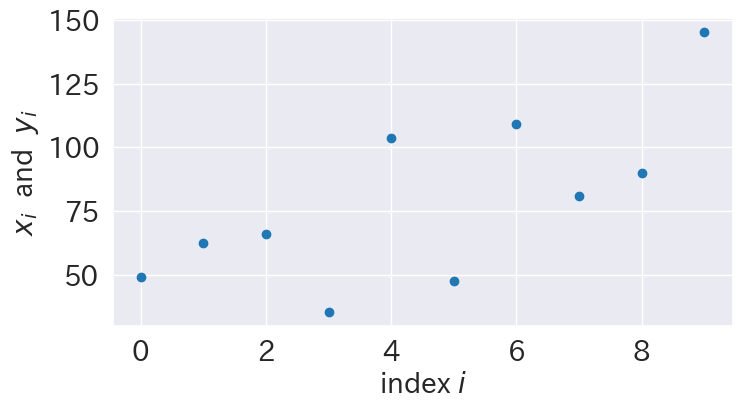

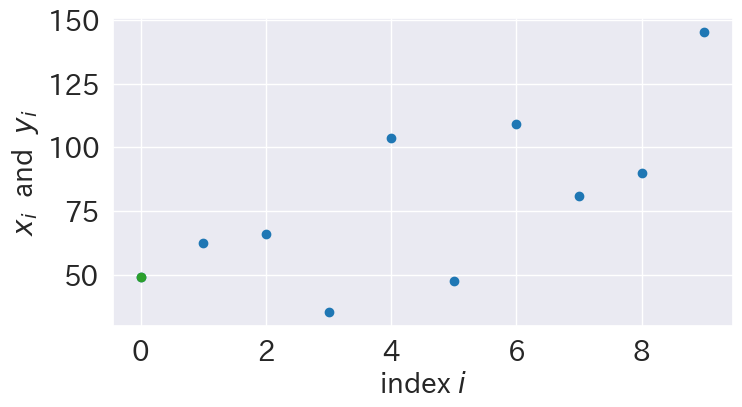

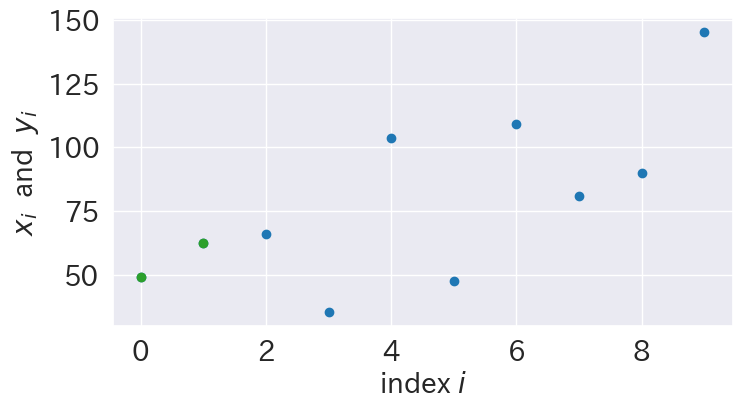

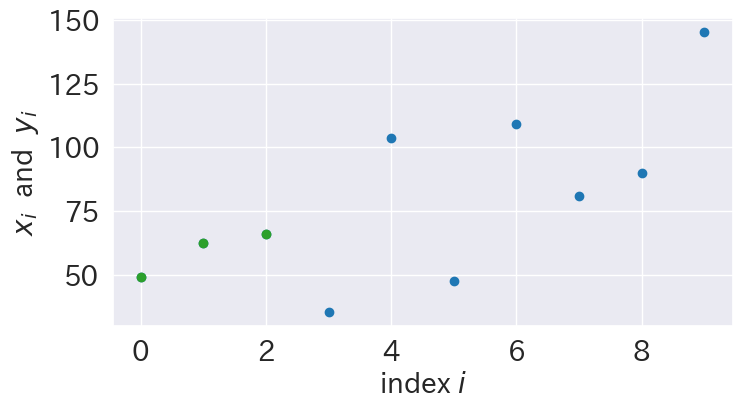

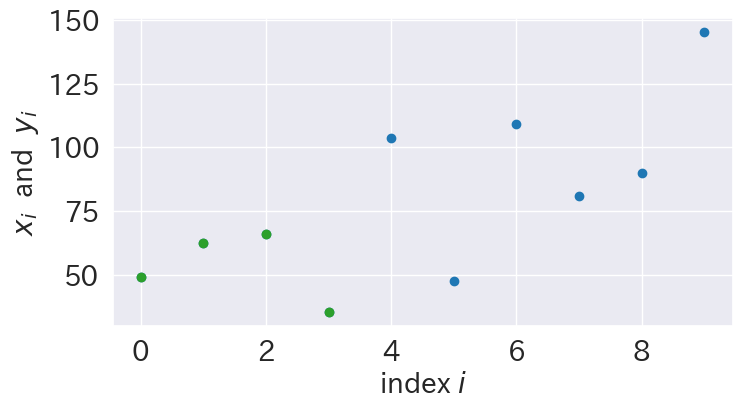

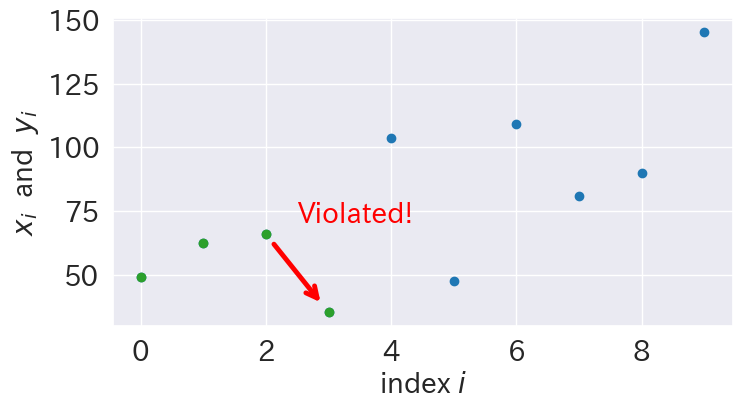

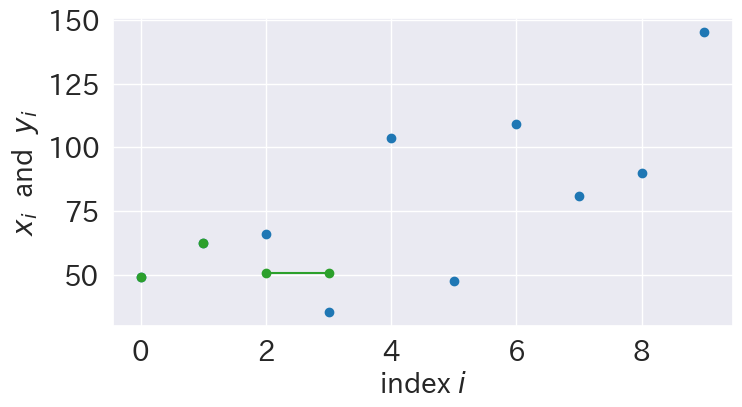

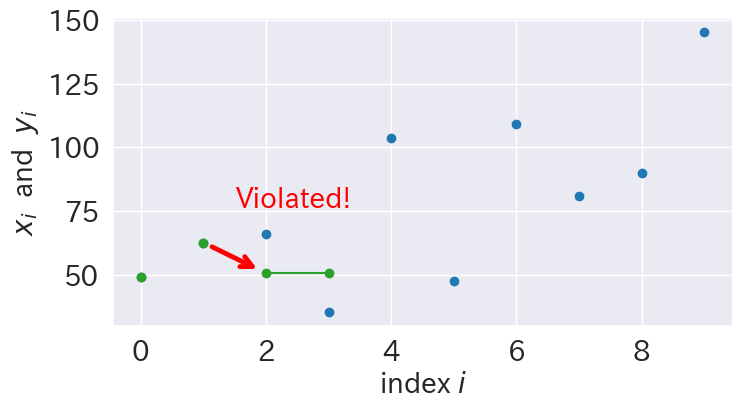

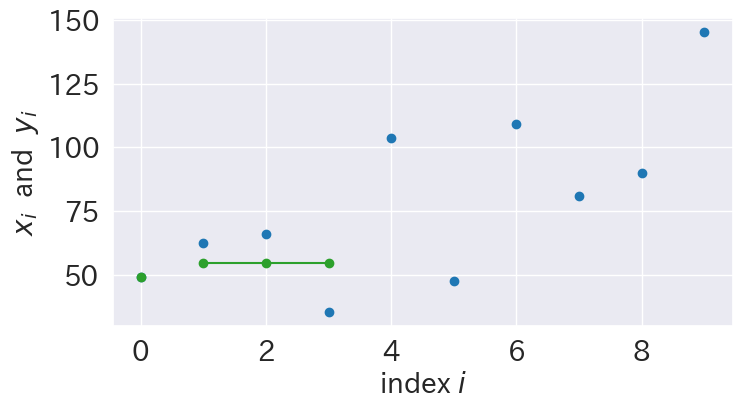

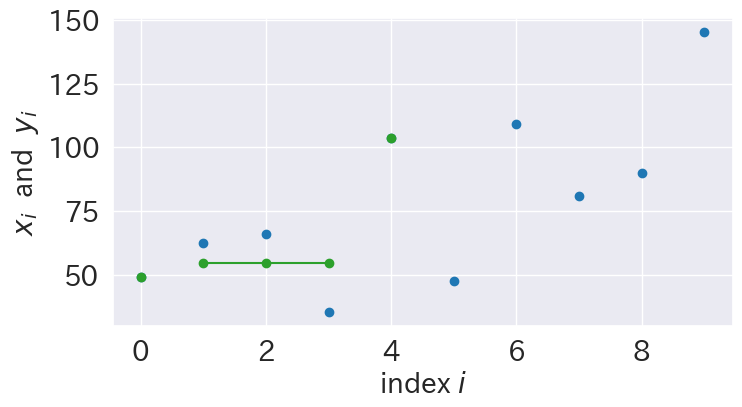

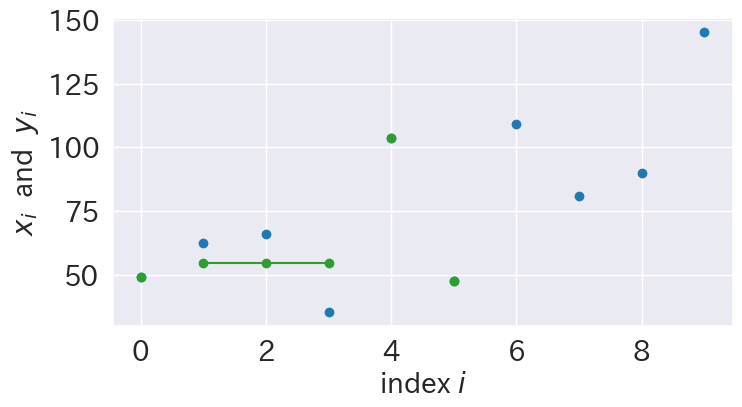

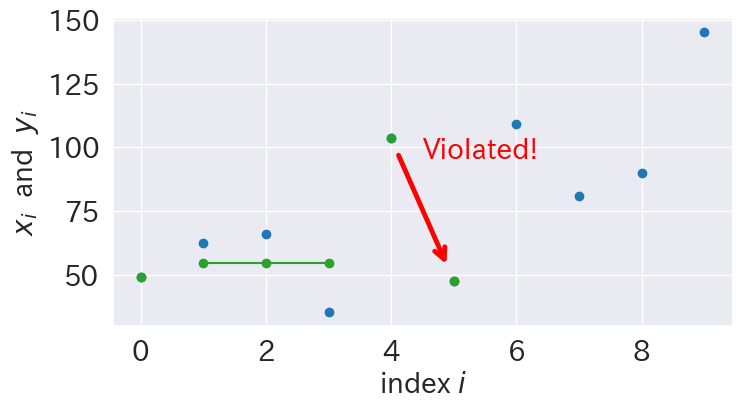

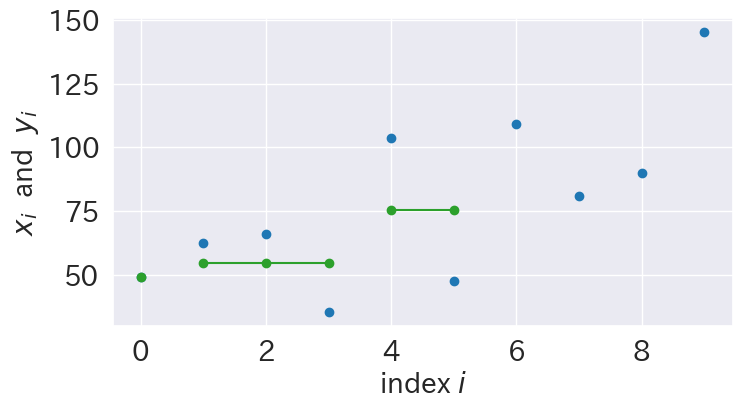

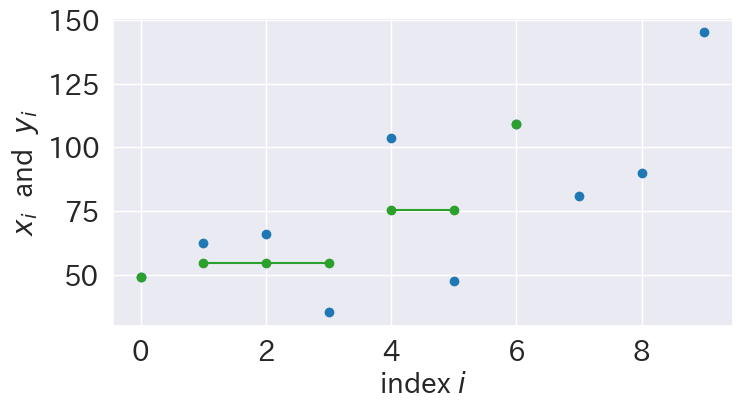

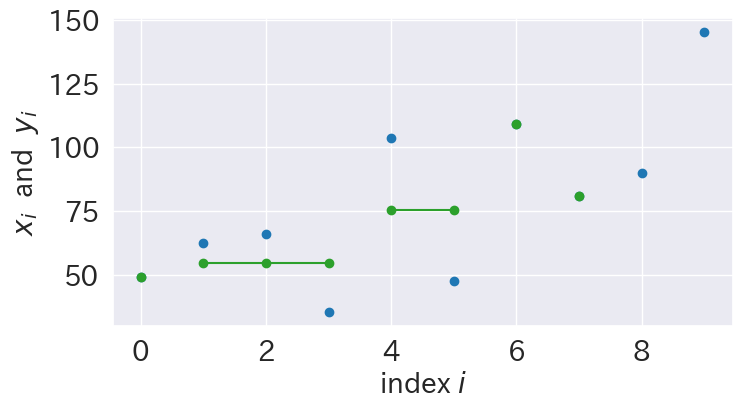

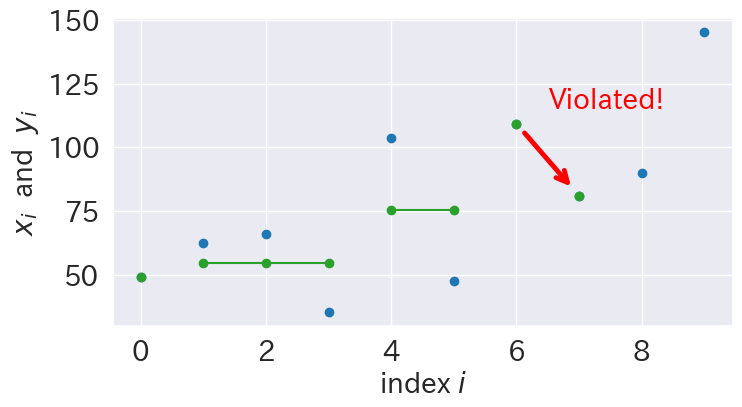

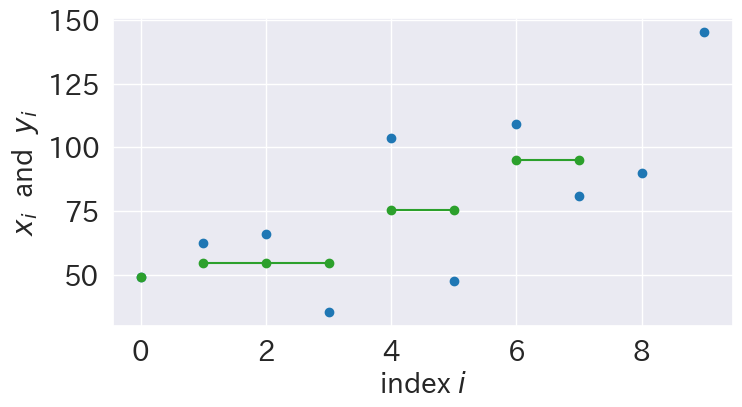

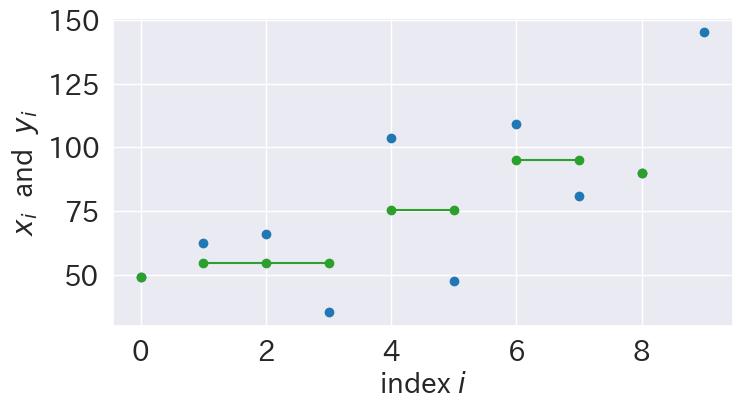

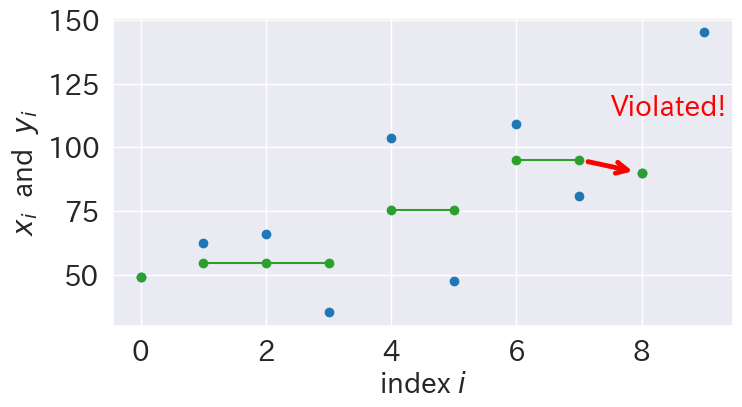

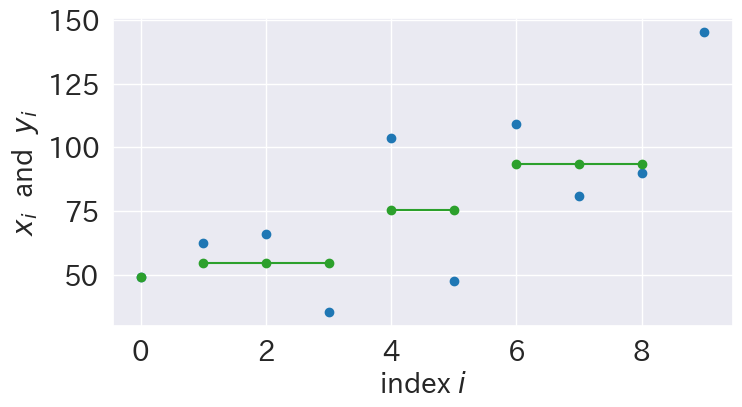

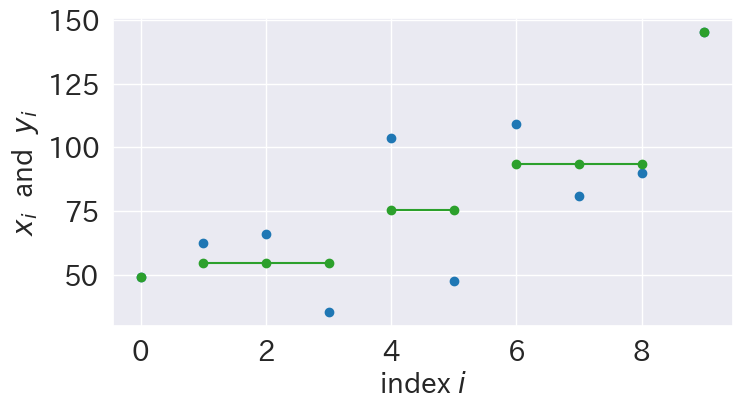

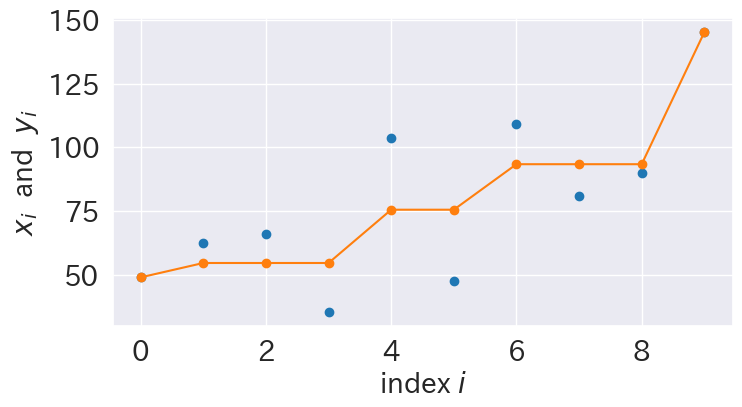

In [48]:
def plot_blocks(
    y: np.ndarray,
    w: np.ndarray,
    blocks: list[Block],
    show_violated: bool,
    result: Union[np.ndarray, None] = None,
) -> None:
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(np.arange(len(y)), y, "C0.", markersize=12)

    if result is None:
        for block in blocks:
            xs = np.array(range(block.start_idx, block.end_idx + 1))
            ax.plot(xs, [block.mean] * len(xs), "C2.-", markersize=12)
    else:
        ax.plot(np.arange(len(result)), result, "C1.-", markersize=12)

    if show_violated and (len(blocks) >= 2 and blocks[-2].mean >= blocks[-1].mean):
        x1 = blocks[-2].end_idx
        x2 = blocks[-1].start_idx
        x1, x2 = x1 + (x2 - x1) * 0.1, x2 - (x2 - x1) * 0.1
        y1 = blocks[-2].mean
        y2 = blocks[-1].mean
        y1, y2 = y1 + (y2 - y1) * 0.1, y2 - (y2 - y1) * 0.1

        plt.annotate(
            "",
            xy=(x2, y2),
            xytext=(x1, y1),
            arrowprops=dict(arrowstyle="->", lw=3.5, color="red"),
        )
        plt.text(
            (x1 + x2) / 2,
            (y1 + y2) / 2 + 20,
            "Violated!",
            fontsize=20,
            color="red",
        )

    ax.set_xlabel("index $i$")
    ax.set_ylabel("$x_i$  and  $y_i$")
    plt.show()


def pava_vis(y: np.ndarray, w: Union[np.ndarray, None] = None) -> np.ndarray:
    x = np.asarray(y, dtype=np.float64)
    if w is None:
        w = np.ones_like(y, dtype=np.float64)
    else:
        w = np.asarray(w, dtype=np.float64)

    n = len(x)
    blocks = []
    plot_blocks(x, w, blocks, False)

    for i in range(n):
        blocks.append(Block(x[i], w[i], i))
        plot_blocks(x, w, blocks, False)
        while len(blocks) >= 2 and blocks[-2].mean >= blocks[-1].mean:
            plot_blocks(x, w, blocks, True)
            last = blocks.pop()
            blocks[-1].merge(last)
            plot_blocks(x, w, blocks, False)

    result = np.zeros_like(x)
    for block in blocks:
        result[block.start_idx : block.end_idx + 1] = block.mean
    plot_blocks(x, w, blocks, False, result)
    return result


y = make_problem(10, 5)
result = pava_vis(y)